In [4]:
import pandas as pd
import geopandas as gpd
from IPython.display import Image
from shapely.geometry import Point, Polygon

### Functions

In [9]:
#turn dataframe into geodataframe
def create_gdf(df, x='longitude', y='latitude'):
    return gpd.GeoDataFrame(df, 
    geometry=gpd.points_from_xy(df[y], df[x]), 
             crs={'init':'EPSG:4326'})

# Sensors

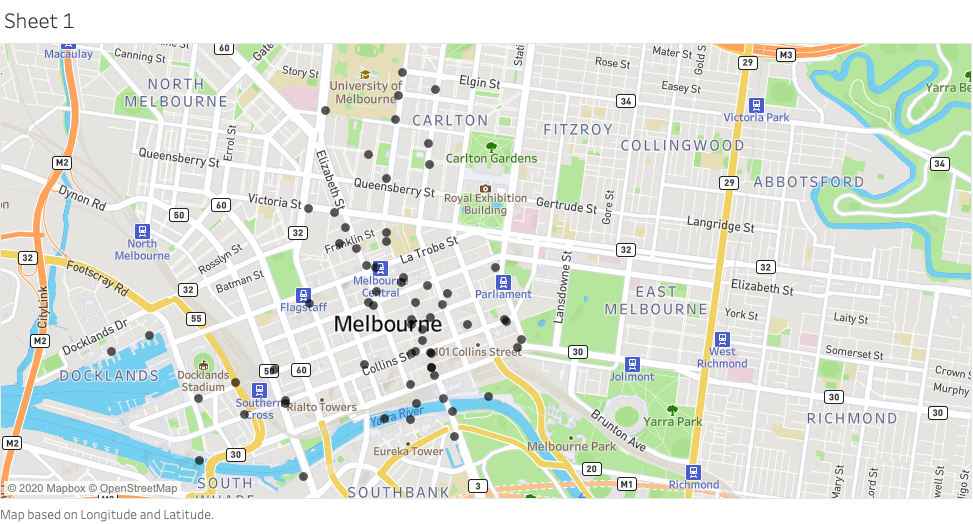

In [10]:
sensors = pd.read_csv('./cleaned datasets/single_sensor_locations.csv')
Image(filename = './visuals/sensor map.png')

## create geo dataframe & make a radius around each point

In [11]:
sensors_gdf = create_gdf(sensors)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
sensors_gdf.head()
#this made a POINT from latitude and longitude

,sensor_id,latitude,longitude,location,geometry
0,1,-37.813494,144.965153,"(-37.8134944, 144.96515324)",POINT (-37.813 144.965)
1,2,-37.813807,144.965167,"(-37.81380667, 144.96516719)",POINT (-37.814 144.965)
2,3,-37.811015,144.964295,"(-37.81101523, 144.96429485)",POINT (-37.811 144.964)
3,4,-37.814880,144.966088,"(-37.81487988, 144.9660878)",POINT (-37.815 144.966)
4,5,-37.818742,144.967877,"(-37.81874249, 144.96787656)",POINT (-37.819 144.968)


In [13]:
sensors_gdf['polygon'] = sensors_gdf.geometry.buffer(0.001)
sensors_gdf.head()

,sensor_id,latitude,longitude,location,geometry,polygon
0,1,-37.813494,144.965153,"(-37.8134944, 144.96515324)",POINT (-37.813 144.965),"POLYGON ((-37.812 144.965, -37.812 144.965, -3..."
1,2,-37.813807,144.965167,"(-37.81380667, 144.96516719)",POINT (-37.814 144.965),"POLYGON ((-37.813 144.965, -37.813 144.965, -3..."
2,3,-37.811015,144.964295,"(-37.81101523, 144.96429485)",POINT (-37.811 144.964),"POLYGON ((-37.810 144.964, -37.810 144.964, -3..."
3,4,-37.814880,144.966088,"(-37.81487988, 144.9660878)",POINT (-37.815 144.966),"POLYGON ((-37.814 144.966, -37.814 144.966, -3..."
4,5,-37.818742,144.967877,"(-37.81874249, 144.96787656)",POINT (-37.819 144.968),"POLYGON ((-37.818 144.968, -37.818 144.968, -3..."


### create geodf that just has each sensor with their point and surrounding radius coordinates

In [14]:
sensor_radius = sensors_gdf[['sensor_id', 'geometry', 'polygon']]
sensor_radius.head()

,sensor_id,geometry,polygon
0,1,POINT (-37.813 144.965),"POLYGON ((-37.812 144.965, -37.812 144.965, -3..."
1,2,POINT (-37.814 144.965),"POLYGON ((-37.813 144.965, -37.813 144.965, -3..."
2,3,POINT (-37.811 144.964),"POLYGON ((-37.810 144.964, -37.810 144.964, -3..."
3,4,POINT (-37.815 144.966),"POLYGON ((-37.814 144.966, -37.814 144.966, -3..."
4,5,POINT (-37.819 144.968),"POLYGON ((-37.818 144.968, -37.818 144.968, -3..."


# Buildings

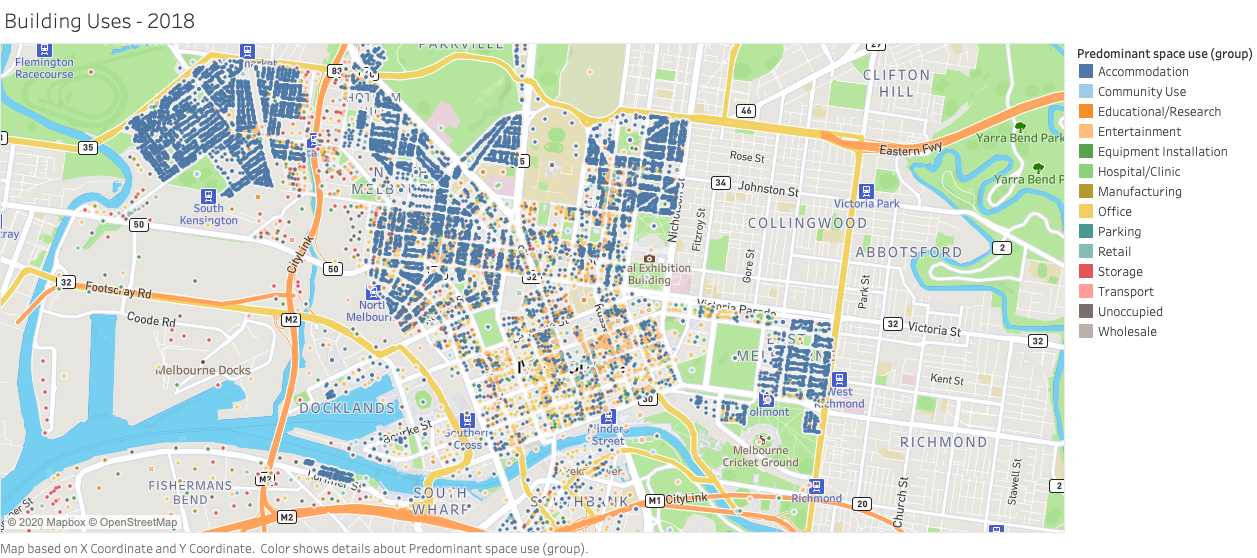

In [15]:
buildings = pd.read_csv('./cleaned datasets/buildings_clean.csv')
Image(filename = './visuals/2018 building use.png')

### create function that returns list of buildings from that year, if there is no buildings nearby, fill the dataframe with zeros


In [16]:
def buildings_per_year(year):
    year_df = buildings[buildings.year == year]
    building_year_gdf = create_gdf(year_df)
    building_year_gdf = building_year_gdf[['n_floors', 'building_use', 'geometry']]
    
    #create list of just coordinate points 
    coords = []
    for x in building_year_gdf.geometry:
        coords.append(list(x.coords))
    new_coords = []
    for y in coords:
        for z in y:
            new_coords.append(z)
            
    #put those coordinates into Geo formatting
    created_point = []
    for point in new_coords:
        created_point.append(Point(point))
        
    #zip lists of number of floors, building type and points into list of tuples
    #this has ALL buildings for the year input
    return list(zip(building_year_gdf.n_floors, building_year_gdf.building_use, created_point))


### returns dataframe with latitude and longitude points of buildings in a specified sensor's radius

In [17]:
def buildings_locations(sensor_num, buildings_per_year):
    building_coord = []
    building_use = []
    n_floors = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in buildings_per_year:
        for geo in gdf['polygon']:
            if geo.contains(x[2]):
                building_coord.append(x[2])
                building_use.append(x[1])
                n_floors.append(x[0])
                
    zipped_sensor = list(zip(building_coord, building_use, n_floors))
    df =  pd.DataFrame(zipped_sensor, columns = ['point', 'building_use', 'n_floors'])
    df['longitude'] = df.point.apply(lambda p: p.x)
    df['latitude'] = df.point.apply(lambda p: p.y)
    return df

In [18]:
buildings_locations(2, buildings_per_year(2011)).head()

,point,building_use,n_floors,longitude,latitude
0,POINT (-37.814 144.9656),Storage,3,-37.8140,144.9656
1,POINT (-37.8138 144.9661),Workshop/Studio,3,-37.8138,144.9661
2,POINT (-37.8139 144.9654),Unoccupied - Unused,6,-37.8139,144.9654
3,POINT (-37.8137 144.966),Retail - Shop,3,-37.8137,144.9660
4,POINT (-37.8142 144.9656),Retail - Shop,3,-37.8142,144.9656


### create dataframe of all location points connected with sensor id

In [19]:
sensor_building_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = buildings_locations(x, buildings_per_year(2018))
    sensor_points['sensor_id'] = x
    sensor_building_points = sensor_building_points.append(sensor_points)

In [20]:
sensor_building_points.to_csv('./location features/features with locations/building_points_2018.csv', header = sensor_building_points.columns, index=False)

### list number of different building types and average number of floors in sensor's radius

In [72]:
#for finding number of different categories of buildings
def buildings_in_radius(sensor_num, buildings_per_year):
    building_coord = []
    building_use = []
    n_floors = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in buildings_per_year:
        for geo in gdf['polygon']:
            if geo.contains(x[2]):
                building_coord.append(x[2])
                building_use.append(x[1])
                n_floors.append(x[0])
                
    if len(building_coord) > 0: 
        dicts = {}
        for x in buildings.building_use.unique():
            dicts[x] = 0
           
        zipped_sensor = list(zip(building_coord, building_use, n_floors))
        df_zip = pd.DataFrame(zipped_sensor, columns = ['point', 'building_use', 'n_floors'])
        group = df_zip.groupby('building_use').agg({'n_floors': 'mean', 'building_use': 'count'})
        transform_group = group.T
        
        #add column with sensor number
        transform_group['sensor_id'] = sensor_num
        
        #add average number of floors as a column         
        transform_group['mean'] = transform_group.mean(axis = 1)
        transform_group['mean'] = transform_group['mean'].shift(1)
        transform_group.drop(['n_floors'], axis = 0, inplace = True)
        transform_group.rename(columns = {'mean': 'avg_n_floors'}, inplace = True)
        
        for col in transform_group.columns:
            dicts[col] = transform_group[col][0]
            
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['avg_n_floors'] = transform_group.avg_n_floors[0]
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df
    
    else:
        dicts = {}
        for x in buildings.building_use.unique():
            dicts[x] = 0
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['avg_n_floors'] = 0
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df

In [73]:
buildings_in_radius(2, buildings_per_year(2011))

,House/Townhouse,Residential Apartment,Parking - Commercial Covered,Retail - Shop,Office,Manufacturing,Unoccupied - Under Renovation,Wholesale,Retail - Showroom,Storage,...,"Performances, Conferences, Ceremonies",Unoccupied - Under Construction,Community Use,Retail - Stall,Parking - Private Covered,Transport,Retail - Cars,Unoccupied - Under Demolition/Condemned,Institutional Accommodation,avg_n_floors
sensor_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,1.0,0.0,9.0,2.0,0.0,1.0,0.0,0.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.800505


# Bikes

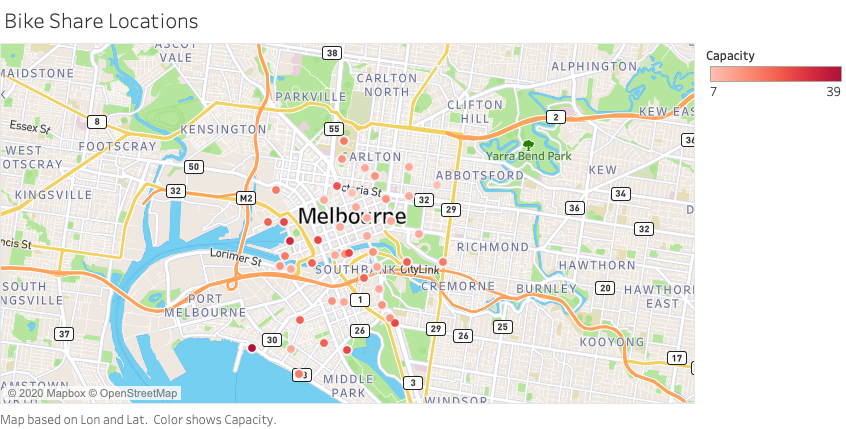

In [5]:
bike = pd.read_csv('./cleaned datasets/bikes_clean.csv')
Image(filename = './visuals/bike map.png')

## make geo dataframe

In [49]:
bike_gdf = create_gdf(bike)
bike_gdf.head()

,station_id,capacity,latitude,longitude,geometry
0,2,23,-37.814022,144.939521,POINT (-37.814 144.940)
1,6,11,-37.810702,144.964417,POINT (-37.811 144.964)
2,7,11,-37.813088,144.967437,POINT (-37.813 144.967)
3,8,19,-37.796250,144.960858,POINT (-37.796 144.961)
4,9,7,-37.807699,144.963095,POINT (-37.808 144.963)


## get location of light feature coordinates in a specific sensor's radius

### returns dataframe with latitude and longitude points of light sources in a specified sensor's radius

In [52]:
def bike_locations(sensor_num):
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    sen_bikes = []
    for point in bike_gdf.geometry:
        for geo in gdf['polygon']:
            if geo.contains(point):
                sen_bikes.append(list(point.coords))
    bike_loc = [x[0] for x in sen_bikes]
    sensor_bikes = pd.DataFrame({'latitude': [x[0] for x in bike_loc], 'longitude': [x[1] for x in bike_loc]})
    return sensor_bikes

In [54]:
bike_locations(3)

,latitude,longitude
0,-37.810702,144.964417


### create dataframe of all location points connected with sensor id

In [165]:
sensor_bike_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = bike_locations(x)
    sensor_points['sensor_id'] = x
    sensor_bike_points = sensor_bike_points.append(sensor_points)

In [166]:
sensor_bike_points.to_csv('./location features/features with locations/bike_points.csv', header = sensor_bike_points.columns, index=False)

### List the number of lights in a sensor's radius

In [55]:
bikes_dict = {}
keys = sensors.sensor_id.unique()
for k in keys:
    bikes_dict[k] = len(bike_locations(k))


In [56]:
#convert dictionary to dataframe
bike_df = pd.DataFrame(bikes_dict.items(), columns=['sensor_id', 'num_bikes'])
bike_df

,sensor_id,num_bikes
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
...,...,...
61,62,0
62,63,1
63,64,0
64,65,0


### return just number of bikes given a specific sensor

In [118]:
def bikes_in_radius(sensor_num):
    return bike_df[bike_df.sensor_id == sensor_num]

In [119]:
bikes_in_radius(2)

,sensor_id,num_bikes
1,2,0


# Lights

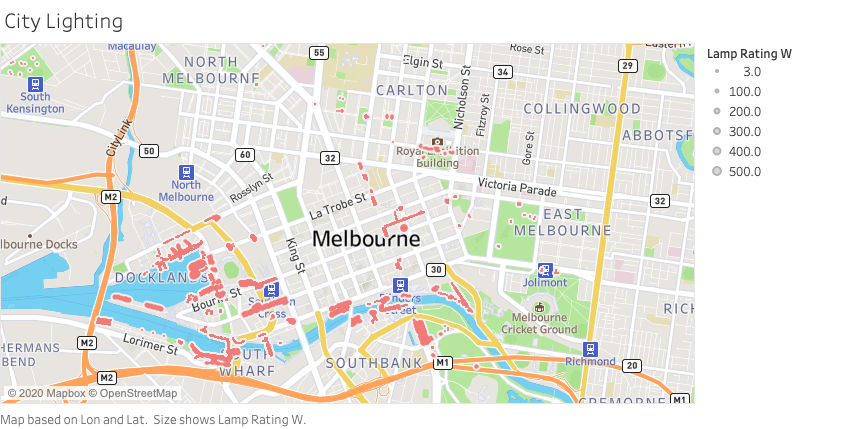

In [6]:
lights = pd.read_csv('./cleaned datasets/lights_clean.csv')
Image(filename = './visuals/lighting map.png')

## make geo dataframe

In [23]:
lights_gdf = create_gdf(lights)
lights_gdf.head()

,lamp_type_lupvalue,lamp_rating_w,latitude,longitude,geometry
0,13.0,70.0,-37.832430,144.972851,POINT (-37.832 144.973)
1,5.0,70.0,-37.819371,144.952721,POINT (-37.819 144.953)
2,5.0,70.0,-37.814309,144.941508,POINT (-37.814 144.942)
3,13.0,35.0,-37.823777,144.947362,POINT (-37.824 144.947)
4,13.0,35.0,-37.823550,144.947258,POINT (-37.824 144.947)


## get location of light feature coordinates in a specific sensor's radius

### returns dataframe with latitude and longitude points of light sources in a specified sensor's radius

In [38]:
def lights_locations(sensor_num):
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    sen_lights = []
    for point in lights_gdf.geometry:
        for geo in gdf['polygon']:
            if geo.contains(point):
                sen_lights.append(list(point.coords))
    light_loc = [x[0] for x in sen_lights]
    sensor_lights = pd.DataFrame({'latitude': [x[0] for x in light_loc], 'longitude': [x[1] for x in light_loc]})
    return sensor_lights

In [47]:
lights_locations(2).head()

,latitude,longitude
0,-37.813007,144.965298
1,-37.813226,144.965399
2,-37.813346,144.965643
3,-37.813012,144.965282
4,-37.813006,144.965507


### create dataframe of all location points connected with sensor id

In [163]:
sensor_light_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = lights_locations(x)
    sensor_points['sensor_id'] = x
    sensor_light_points = sensor_light_points.append(sensor_points)

In [164]:
sensor_light_points.to_csv('./location features/features with locations/light_points.csv', header = sensor_light_points.columns, index=False)

### List the number of lights in a sensor's radius

In [44]:
light_dict = {}
keys = sensors.sensor_id.unique()
for k in keys:
    light_dict[k] = len(lights_locations(k))


In [46]:
#convert dictionary to dataframe
lighting_df = pd.DataFrame(light_dict.items(), columns=['sensor_id', 'num_lights'])
lighting_df

,sensor_id,num_lights
0,1,56
1,2,44
2,3,31
3,4,0
4,5,47
...,...,...
61,62,0
62,63,0
63,64,0
64,65,121


In [120]:
def lights_in_radius(sensor_num):
    return lighting_df[lighting_df.sensor_id == sensor_num]

In [121]:
lights_in_radius(2)

,sensor_id,num_lights
1,2,44


# Landmarks

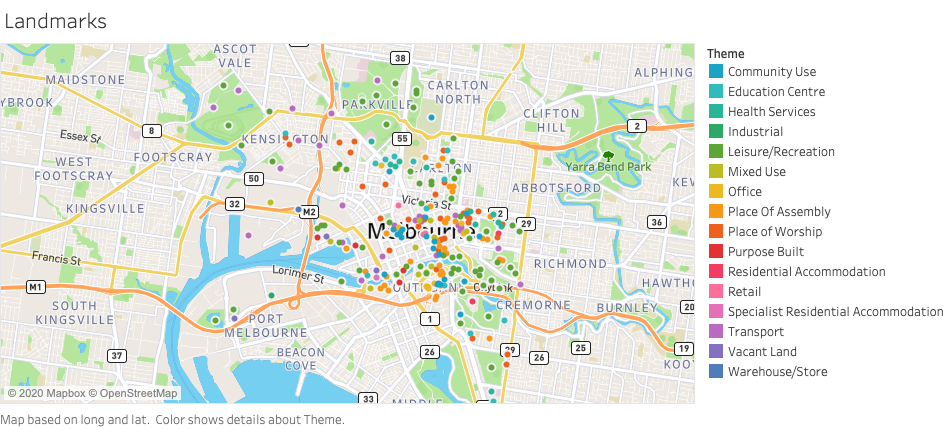

In [7]:
landmarks = pd.read_csv('./cleaned datasets/landmarks_clean.csv')
Image(filename = './visuals/landmarks.png')

### create gdf

In [75]:
landmarks_gdf = create_gdf(landmarks)
landmarks_gdf.head()

,theme,sub_theme,feature_name,latitude,longitude,geometry
0,Transport,Railway Station,Flemington Bridge Railway Station,-37.788165,144.939278,POINT (-37.788 144.939)
1,Mixed Use,Retail/Office/Carpark,Council House 2 (CH2),-37.814259,144.966638,POINT (-37.814 144.967)
2,Place Of Assembly,Library,The Melbourne Athenaeum Library,-37.814886,144.967291,POINT (-37.815 144.967)
3,Leisure/Recreation,Informal Outdoor Facility (Park/Garden/Reserve),Carlton Gardens South,-37.806068,144.971266,POINT (-37.806 144.971)
4,Place of Worship,Church,St Francis Church,-37.811885,144.962423,POINT (-37.812 144.962)


In [89]:
 #zip lists of theme and point
landmark_zip_list =  list(zip(landmarks_gdf.theme,landmarks_gdf.geometry))
landmark_zip_list[:10]

[('Transport', <shapely.geometry.point.Point at 0x1291c4a10>),
 ('Mixed Use', <shapely.geometry.point.Point at 0x1291c4a90>),
 ('Place Of Assembly', <shapely.geometry.point.Point at 0x1291c4a50>),
 ('Leisure/Recreation', <shapely.geometry.point.Point at 0x1291c4ad0>),
 ('Place of Worship', <shapely.geometry.point.Point at 0x12652c410>),
 ('Place of Worship', <shapely.geometry.point.Point at 0x12652cfd0>),
 ('Place of Worship', <shapely.geometry.point.Point at 0x12652c3d0>),
 ('Place of Worship', <shapely.geometry.point.Point at 0x1291a2310>),
 ('Place of Worship', <shapely.geometry.point.Point at 0x1291c4b50>),
 ('Place of Worship', <shapely.geometry.point.Point at 0x12652c050>)]

### returns data frame with location coordinates and theme of landmarks in a sensor's radius

In [94]:
def landmarks_coords(sensor_num):
    landmark_coord = []
    theme = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in landmark_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                landmark_coord.append(x[1])
                theme.append(x[0])
    zipped_sensor = list(zip(landmark_coord, theme))
    landmark = pd.DataFrame(zipped_sensor, columns = ['point', 'theme'])
    landmark['longitude'] = landmark.point.apply(lambda p: p.x)
    landmark['latitude'] = landmark.point.apply(lambda p: p.y)
    return landmark

In [95]:
landmarks_coords(2)

,point,theme,longitude,latitude
0,POINT (-37.8139525061193 144.964425882562),Community Use,-37.813953,144.964426
1,POINT (-37.81331272606379 144.964373486798),Retail,-37.813313,144.964373


### create dataframe of all location points connected with sensor id

In [161]:
sensor_landmark_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = landmarks_coords(x)
    sensor_points['sensor_id'] = x
    sensor_landmark_points = sensor_landmark_points.append(sensor_points)

In [162]:
sensor_landmark_points.to_csv('./location features/features with locations/landmark_points.csv', header = sensor_landmark_points.columns, index=False)

### returns number of different themes of landmarks in a sensor's radius

In [92]:
def landmarks_in_radius(sensor_num):
    landmark_coord = []
    theme = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in landmark_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                landmark_coord.append(x[1])
                theme.append(x[0])
                
    if len(landmark_coord) > 0: 
        dicts = {}
        for x in landmarks.theme.unique():
            dicts[x] = 0
           
        zipped_sensor = list(zip(landmark_coord, theme))
        df_zip = pd.DataFrame(zipped_sensor, columns = ['point', 'theme'])
        group = df_zip.groupby('theme').agg({'point': 'count'})
        transform_group = group.T
        
        for col in transform_group.columns:
            dicts[col] = transform_group[col][0]
            
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df
    
    else:
        dicts = {}
        for x in landmarks.theme.unique():
            dicts[x] = 0
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df

In [93]:
landmarks_in_radius(2)

,Transport,Mixed Use,Place Of Assembly,Leisure/Recreation,Place of Worship,Health Services,Community Use,Retail,Education Centre,Office,Vacant Land,Purpose Built,Specialist Residential Accommodation,Residential Accommodation,Industrial,Warehouse/Store
sensor_id,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


# Street Infrastructure

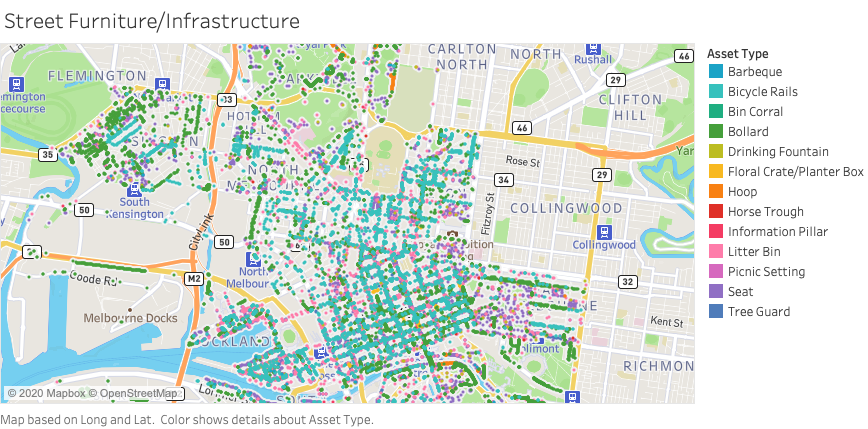

In [8]:
street_inf = pd.read_csv('./cleaned datasets/street_inf_clean.csv')
Image(filename = './visuals/furniture map.png')

### create gdf

In [96]:
furniture_gdf = create_gdf(street_inf)
furniture_gdf.head()

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,feature,condition_rating,latitude,longitude,geometry
0,Bicycle Rails,4.00,-37.809943,144.969855,POINT (-37.810 144.970)
1,Bicycle Rails,3.78,-37.802292,144.959639,POINT (-37.802 144.960)
2,Bicycle Rails,3.69,-37.810588,144.957095,POINT (-37.811 144.957)
3,Bicycle Rails,3.64,-37.796411,144.942284,POINT (-37.796 144.942)
4,Bicycle Rails,3.71,-37.804291,144.967971,POINT (-37.804 144.968)


In [100]:
#create list of type of features and point
furniture_zip_list =  list(zip(furniture_gdf['feature'],furniture_gdf['geometry']))
furniture_zip_list[:10]

[('Bicycle Rails', <shapely.geometry.point.Point at 0x12a018e10>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x129dd7ed0>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x12a0185d0>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x12a018f90>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x12a0180d0>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x12a018490>),
 ('Litter Bin', <shapely.geometry.point.Point at 0x12a018b10>),
 ('Litter Bin', <shapely.geometry.point.Point at 0x12a4d0cd0>),
 ('Seat', <shapely.geometry.point.Point at 0x12a4d0a90>),
 ('Seat', <shapely.geometry.point.Point at 0x1297f8450>)]

In [103]:
def furniture_coords(sensor_num):
    furniture_coord = []
    feature = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in furniture_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                furniture_coord.append(x[1])
                feature.append(x[0])
                
    zipped_sensor = list(zip(furniture_coord, feature))
    furniture = pd.DataFrame(zipped_sensor, columns = ['point', 'feature'])
    furniture['longitude'] = furniture.point.apply(lambda p: p.x)
    furniture['latitude'] = furniture.point.apply(lambda p: p.y)
    return furniture

In [104]:
furniture_coords(2)

,point,feature,longitude,latitude
0,POINT (-37.81390544551112 144.9659069655714),Seat,-37.813905,144.965907
1,POINT (-37.81366664015143 144.9658082187148),Bicycle Rails,-37.813667,144.965808
2,POINT (-37.81400590195589 144.9659524858654),Bicycle Rails,-37.814006,144.965952
3,POINT (-37.81371435439695 144.9656124361659),Bicycle Rails,-37.813714,144.965612
4,POINT (-37.8140979245522 144.9657914956971),Bicycle Rails,-37.814098,144.965791
...,...,...,...,...
227,POINT (-37.81377837958882 144.9650151050156),Bollard,-37.813778,144.965015
228,POINT (-37.81378830483876 144.9650523185062),Bollard,-37.813788,144.965052
229,POINT (-37.81380011464495 144.9650577875143),Bollard,-37.813800,144.965058
230,POINT (-37.81381274493579 144.9650638019645),Bollard,-37.813813,144.965064


### create dataframe of all location points connected with sensor id

In [157]:
sensor_furniture_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = furniture_coords(x)
    sensor_points['sensor_id'] = x
    sensor_furniture_points = sensor_furniture_points.append(sensor_points)

In [159]:
sensor_furniture_points.to_csv('./location features/features with locations/furniture_points.csv', header = sensor_furniture_points.columns, index=False)

### find number of features in sensor's radius, if there is none of a type, return 0

In [114]:
def furniture_in_radius(sensor_num):
    furniture_coord = []
    feature = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in furniture_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                furniture_coord.append(x[1])
                feature.append(x[0])
                
    if len(furniture_coord) > 0: 
        dicts = {}
        for x in furniture_gdf['feature'].unique():
            dicts[x] = 0
           
        zipped_sensor = list(zip(furniture_coord, feature))
        df_zip = pd.DataFrame(zipped_sensor, columns = ['point', 'feature'])
        group = df_zip.groupby('feature').agg({'point': 'count'})
        transform_group = group.T
        
        for col in transform_group.columns:
            dicts[col] = transform_group[col][0]
            
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df
    
    else:
        dicts = {}
        for x in furniture_gdf['feature'].unique():
            dicts[x] = 0
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df

In [115]:
furniture_in_radius(2)

,Bicycle Rails,Litter Bin,Seat,Bollard,Hoop,Information Pillar,Floral Crate/Planter Box,Tree Guard,Drinking Fountain,Horse Trough,Barbeque,Picnic Setting,Bin Corral
sensor_id,,,,,,,,,,,,,
2,26,17,84,80,0,2,20,0,3,0,0,0,0


# Create a dataframe with all the features in a sensor's radius, per year

In [132]:
def sensor_features_per_year(sensor_num, year):
    return pd.concat([furniture_in_radius(sensor_num), landmarks_in_radius(sensor_num),  buildings_in_radius(sensor_num, buildings_per_year(year)),
           bike_df.loc[[sensor_num]], lighting_df.loc[[sensor_num]]], axis = 1)



In [133]:
sensor_features_per_year(2, 2012)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Bicycle Rails,Litter Bin,Seat,Bollard,Hoop,Information Pillar,Floral Crate/Planter Box,Tree Guard,Drinking Fountain,Horse Trough,...,Parking - Private Covered,Transport,Retail - Cars,Unoccupied - Under Demolition/Condemned,Institutional Accommodation,avg_n_floors,sensor_id,num_bikes,sensor_id,num_lights
2,26,17,84,80,0,2,20,0,3,0,...,0.0,0.0,0.0,0.0,0.0,6.266667,3,1,3,31


## Make full dataframe per year, with all sensors that are valid for that period
yearly list of valid sensors is pulled from the data cleaning notebook

In [134]:
sensors_2011 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
sensors_2012 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
sensors_2013 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18]
sensors_2014 = [2,3,4,5,6,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
sensors_2015 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40]
sensors_2016 = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 53]
sensors_2017 = [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 37, 39, 40, 42, 43, 44, 53]
sensors_2018 = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
sensors_2019 = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 30, 31, 34, 35, 36, 37, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58]

In [151]:
def features_per_year(year, year_list):
    year_df = pd.DataFrame([])
    for x in year_list:
        year_df = year_df.append(sensor_features_per_year(x, year))
        
    df = year_df.loc[:,~year_df.columns.duplicated()]
    #save to csv
    df.to_csv('./location features/features_{}.csv'.format(year), header = df.columns, index=True)
    
    

In [152]:
features_per_year(2011, sensors_2011)
features_per_year(2012, sensors_2012)
features_per_year(2013, sensors_2013)
features_per_year(2014, sensors_2014)
features_per_year(2015, sensors_2015)
features_per_year(2016, sensors_2016)
features_per_year(2017, sensors_2017)
features_per_year(2018, sensors_2018)